# Esercitazione 7

## Equilibrazione e autocorrelazione

In questo esercizio devo calcolare la funzione di correlazione per stabilire quanto grandi devono essere i blocchi. Prima di fare questo è pero necessario raggiungere l'equilibrazione del sistema. Per controllare dopo quanti passi raggiungo l'equilibrazione faccio delle simulazioni da $1000$ passi Metropolis e guardo come variano l'energia interna e la pressione.

### Solido

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Definisco fattori di conversiore da unità di Lennard-Jones
unitàP = 415.8 # In atmosfere
unitàE = 0.0103 # In eV
unitàL = 0.34 # In nm

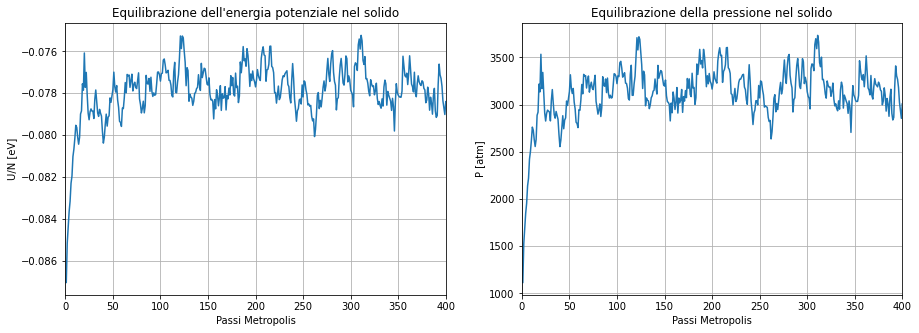

In [132]:
# Carica i dati
epot = np.loadtxt("../Esercizio7/output.epot.insta", usecols=(0), unpack='true')
pres = np.loadtxt("../Esercizio7/output.pres.insta", usecols=(0), unpack='true')

# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Grafico per l'energia potenziale
x = np.arange(1000) + 1
ax1.plot(x, epot * unitàE)
ax1.set_xlabel('Passi Metropolis')
ax1.set_ylabel('U/N [eV]')
ax1.set_title("Equilibrazione dell'energia potenziale nel solido")
ax1.set_xlim(0,400)
ax1.grid(True)

# Grafico per la pressione
ax2.plot(x, pres * unitàP)
ax2.set_xlabel('Passi Metropolis')
ax2.set_ylabel('P [atm]')
ax2.set_title("Equilibrazione della pressione nel solido")
ax2.set_xlim(0,400)
ax2.grid(True)

Dai grafici si deduce che per il solido $200$ passi Metropolis bastano per l'equilibrazione. Per il calcolo dell'autocorrelazione salvo l'energia potenziale e la pressione ogni step Metropolis per un totale di $5$ $10^5$ punti. Il calcolo dell'autocorrelazione è dato da 

$$ A(\tau) = \frac{cov_{[x,x]}(t, t+\tau)}{\sqrt{cov_{[x,x]}(t, t) cov_{[x,x]}(t+\tau, t+\tau)}} = \frac{cov_{[x,x]}(t, t+\tau)}{\sigma^2_x}$$

dove $x$ sono i dati di cui voglio calcolare l'autocorrelazione. Nel secondo passaggio ho sfruttato il fatto che le medie dei miei valori non dipendono dal tempo e quindi il denominatore si riduce alla varianza dei dati campionati. Per il solido si ottiene il seguente grafico.

In [57]:
# Definisco una funzione per il calcolo dell'autocorrelazione
def Autocorrelazione(dati, tempo): 
    covarianza = np.cov(dati[:-tempo], dati[tempo:])
    return covarianza[0,1] / covarianza[0,0]

In [58]:
# Carica i dati
energia_insta = np.loadtxt("../Esercizio7/output.epot.insta", usecols=(0), unpack='true')
pressione_insta = np.loadtxt("../Esercizio7/output.pres.insta", usecols=(0), unpack='true')

In [59]:
# Vettore per calcolare l'autocorrelazione a diversi valori
tempi = [i for i in range(5, 201, 5)]
Ac_energia = []
Ac_pressione = []

# Calcola le autocorrelazioni
for tempo in tempi:
    Ac_energia.append(Autocorrelazione(energia_insta, tempo))
    Ac_pressione.append(Autocorrelazione(pressione_insta, tempo))

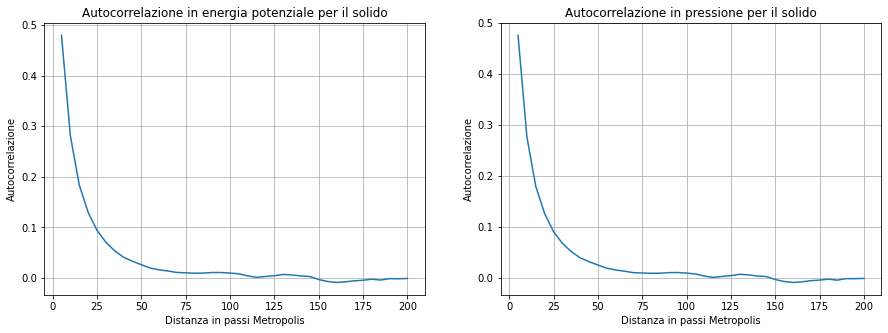

In [62]:
# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Grafico per l'energia potenziale
ax1.plot(tempi, Ac_energia)
ax1.set_xlabel('Distanza in passi Metropolis')
ax1.set_ylabel('Autocorrelazione')
ax1.set_title("Autocorrelazione in energia potenziale per il solido")
ax1.grid(True)

# Grafico per la pressione
ax2.plot(tempi, Ac_pressione)
ax2.set_xlabel('Distanza in passi Metropolis')
ax2.set_ylabel('Autocorrelazione')
ax2.set_title("Autocorrelazione in pressione per il solido")
ax2.grid(True)

Guardando l'autocorrelazione si vede che dopo circa un centinaio di passi Metropolis le misure non sono più correlate. La dimensione dei blocchi deve essere tale da contenere diverse lunghezze di correlazione, di conseguenza prendere dei blocchi di $1000$ step Metropolis dovrebbe essere sufficiente.

Adesso utilizzo i dati usati nel calcolo dell'autocorrelazione per provare a vedere cosa succede se il numero di passi Metropolis è troppo basso. Questo funge anche da controllo per verificare se $1000$ passi sono sufficienti per il calcolo di un blocco. Nel seguente specchietto python implemento il calcolo della media a blocchi, successivamente divido i dati utilizzando blocchi di dimensione diversa. La lunghezza minima che utilizzo per i blocchi è $10$ e la massima è $5000$.

In [109]:
# Funzione per il calcolo della media a blocchi
def mediablocchi(dati, blocchi):
    ave = 0
    ave2 = 0
    length = int(len(dati) / blocchi)
    
    #Calcola il valore di un blocco alla volta
    for i in range(blocchi):
        sum = 0
        for j in range(length):
            sum += dati[j + i * length]
        sum /= length
        ave += sum
        ave2 += sum**2

    # Calcola medie ed errore
    ave /= blocchi
    ave2 /= blocchi
    err = np.sqrt((ave2 - ave**2) / (blocchi - 1))
    return ave, err

In [122]:
# Crea un vettore con il numero dei blocchi e calcola i risultati
N = [50000, 25000, 20000, 10000, 5000, 2500, 1000, 500, 250, 100]
L = [5e5 / i for i in N]
blocchi_ene = np.array([mediablocchi(energia_insta, nblocchi) for nblocchi in N])
blocchi_pres = np.array([mediablocchi(pressione_insta, nblocchi) for nblocchi in N])

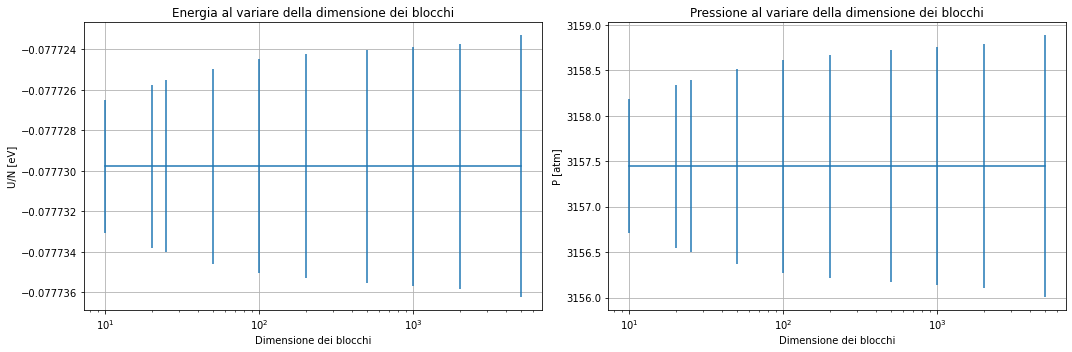

In [125]:
# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), tight_layout = True)

# Grafico per l'energia potenziale
ax1.errorbar(L, blocchi_ene[:,0] * unitàE, yerr = blocchi_ene[:,1] * unitàE)
ax1.set_xlabel('Dimensione dei blocchi')
ax1.set_ylabel('U/N [eV]')
ax1.set_title("Energia al variare della dimensione dei blocchi")
ax1.set_xscale("log")
ax1.grid(True)

# Grafico per la pressione
ax2.errorbar(L, blocchi_pres[:,0] * unitàP, yerr = blocchi_pres[:,1] * unitàP)
ax2.set_xlabel('Dimensione dei blocchi')
ax2.set_ylabel('P [atm]')
ax2.set_title("Pressione al variare della dimensione dei blocchi")
ax2.set_xscale("log")
ax2.grid(True)

Dai grafici si nota che aumentando la dimensione dei blocchi aumenta anche l'incertezza finchè non si stabilizza intorno al valore corretto; questo avviene in corrispondenza di circa $500$ passi Metropolis per blocco. Usare blocchi di dimensione troppo piccola sottostima l'errore. I due grafici giustificano quindi l'utilizzo di blocchi di dimensione $1000$ step.

### Liquido

Come nel caso del solido come prima cosa guardo l'equilibrazione del liquido. Parto da una configurazione fcc.

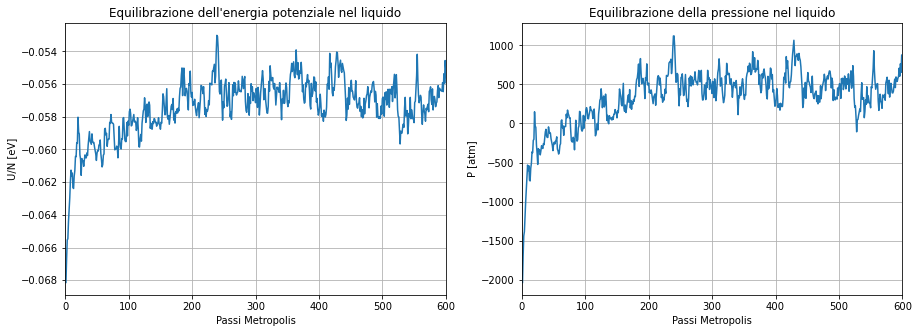

In [136]:
# Carica i dati
epot = np.loadtxt("../Esercizio7/output.epot.insta", usecols=(0), unpack='true')
pres = np.loadtxt("../Esercizio7/output.pres.insta", usecols=(0), unpack='true')

# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Grafico per l'energia potenziale
x = np.arange(1000) + 1
ax1.plot(x, epot * unitàE)
ax1.set_xlabel('Passi Metropolis')
ax1.set_ylabel('U/N [eV]')
ax1.set_title("Equilibrazione dell'energia potenziale nel liquido")
ax1.set_xlim(0,600)
ax1.grid(True)

# Grafico per la pressione
ax2.plot(x, pres * unitàP)
ax2.set_xlabel('Passi Metropolis')
ax2.set_ylabel('P [atm]')
ax2.set_title("Equilibrazione della pressione nel liquido")
ax2.set_xlim(0,600)
ax2.grid(True)

Dai grafici si deduce che per il liquido sono necessari circa $500$ passi Metropolis per ottenere una configurazione di equilibrio. Adesso faccio la simulazione per l'autocorrelazione, come nel caso precedente prima faccio una equilibrazione e poi genero $5$ $10^5$ valori instantanei di energia potenziale e pressione.

In [126]:
# Carica i dati
energia_insta = np.loadtxt("../Esercizio7/output.epot.insta", usecols=(0), unpack='true')
pressione_insta = np.loadtxt("../Esercizio7/output.pres.insta", usecols=(0), unpack='true')

In [127]:
# Vettore per calcolare l'autocorrelazione a diversi valori
tempi = [i for i in range(20, 401, 20)]
Ac_energia = []
Ac_pressione = []

# Calcola le autocorrelazioni
for tempo in tempi:
    Ac_energia.append(Autocorrelazione(energia_insta, tempo))
    Ac_pressione.append(Autocorrelazione(pressione_insta, tempo))

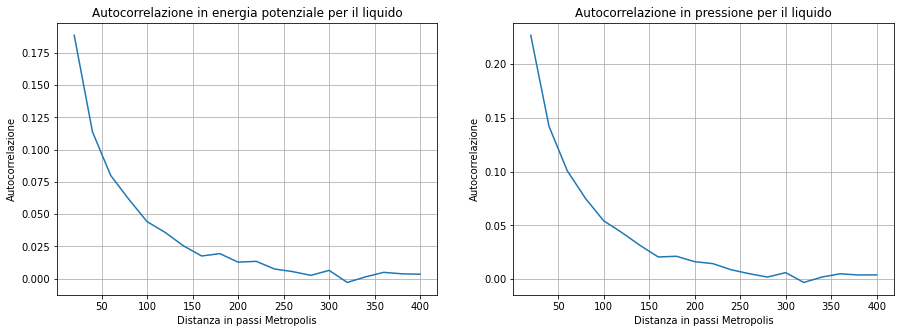

In [131]:
# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Grafico per l'energia potenziale
ax1.plot(tempi, Ac_energia)
ax1.set_xlabel('Distanza in passi Metropolis')
ax1.set_ylabel('Autocorrelazione')
ax1.set_title("Autocorrelazione in energia potenziale per il liquido")
ax1.grid(True)

# Grafico per la pressione
ax2.plot(tempi, Ac_pressione)
ax2.set_xlabel('Distanza in passi Metropolis')
ax2.set_ylabel('Autocorrelazione')
ax2.set_title("Autocorrelazione in pressione per il liquido")
ax2.grid(True)

In questo caso sono necessari circa $300$ passi Metropolis per ottenere una configurazione statisticamente indipendente da quella di partenza. Come nel caso del solido guardo come varia l'incertezza con la dimensione dei blocchi per stabilire la loro lunghezza.

In [129]:
# Calcola l'incertezza ottenuta dividendo in blocchi di lunghezza diversa
blocchi_ene = np.array([mediablocchi(energia_insta, nblocchi) for nblocchi in N])
blocchi_pres = np.array([mediablocchi(pressione_insta, nblocchi) for nblocchi in N])

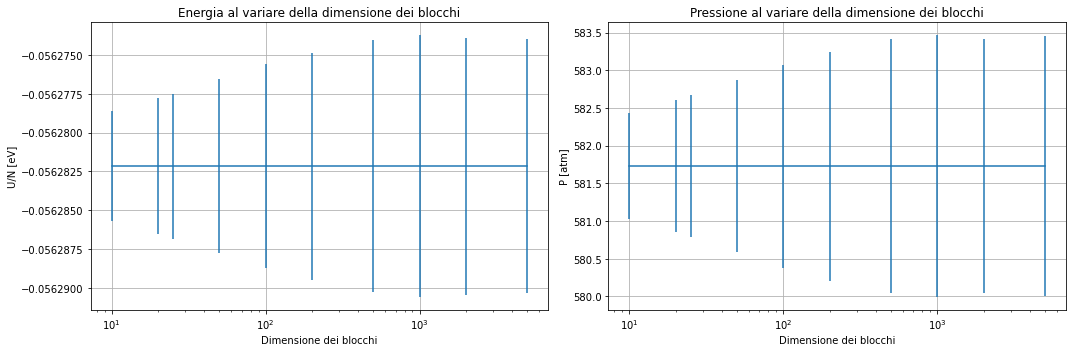

In [130]:
# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), tight_layout = True)

# Grafico per l'energia potenziale
ax1.errorbar(L, blocchi_ene[:,0] * unitàE, yerr = blocchi_ene[:,1] * unitàE)
ax1.set_xlabel('Dimensione dei blocchi')
ax1.set_ylabel('U/N [eV]')
ax1.set_title("Energia al variare della dimensione dei blocchi")
ax1.set_xscale("log")
ax1.grid(True)

# Grafico per la pressione
ax2.errorbar(L, blocchi_pres[:,0] * unitàP, yerr = blocchi_pres[:,1] * unitàP)
ax2.set_xlabel('Dimensione dei blocchi')
ax2.set_ylabel('P [atm]')
ax2.set_title("Pressione al variare della dimensione dei blocchi")
ax2.set_xscale("log")
ax2.grid(True)

Si vede nuovamente che quando la dimensione dei blocchi è piccola, l'errore è sottostimato. Si raggiunge una condizione di equilibrio sull'errore quando si usano blocchi da $500$ passi Metropolis, di conseguenza posso continuare a usare blocchi di dimensione $1000$.

### Gas

Calcolo per il gas il tempo di equilibrazione. Come nei casi precedenti parto dalla configurazione fcc e faccio $1000$ passi Metropolis.

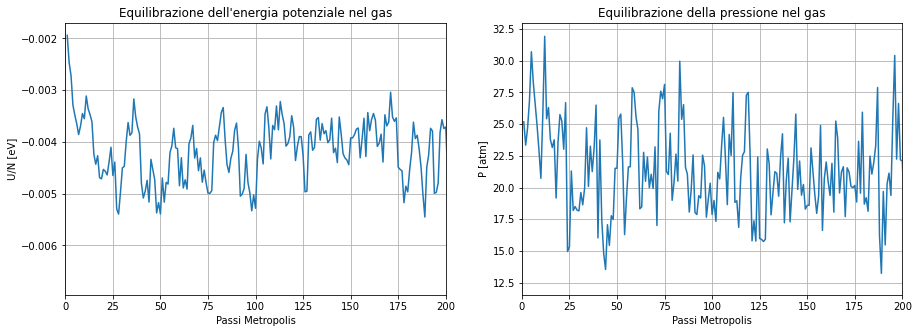

In [139]:
# Carica i dati
epot = np.loadtxt("../Esercizio7/output.epot.insta", usecols=(0), unpack='true')
pres = np.loadtxt("../Esercizio7/output.pres.insta", usecols=(0), unpack='true')

# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Grafico per l'energia potenziale
x = np.arange(1000) + 1
ax1.plot(x, epot * unitàE)
ax1.set_xlabel('Passi Metropolis')
ax1.set_ylabel('U/N [eV]')
ax1.set_title("Equilibrazione dell'energia potenziale nel gas")
ax1.set_xlim(0,200)
ax1.grid(True)

# Grafico per la pressione
ax2.plot(x, pres * unitàP)
ax2.set_xlabel('Passi Metropolis')
ax2.set_ylabel('P [atm]')
ax2.set_title("Equilibrazione della pressione nel gas")
ax2.set_xlim(0,200)
ax2.grid(True)

Vediamo che l'equilibrazione del gas è la più veloce delle tre. Questo è probabilmente dovuto al fatto che in questa simulazione ho usato una lunghezza del passo Metropolis decisamente maggiore rispetto alle simulazioni precedenti. In questo caso ho utilizzato un passo di lunghezza $3$ avendo un box di lato $12.9$, mentre ad esempio nel solido avevo il lato del box di $4.6$ e facevo passi di $0.12$. Questa grossa differenza è dovuta all'accettazione del Metropolis: per il solido e il liquido con un passo breve riuscivo a ottenere una accettazione del $50 \%$, mentre nel gas anche con un passo di lunghezza $3$ l'accettazione non scende sotto il $60 \%$.

Adesso calcolo l'autocorrelazione facendo una simulazione di $5$ $10^5$ step Metropolis.

In [140]:
# Carica i dati
energia_insta = np.loadtxt("../Esercizio7/output.epot.insta", usecols=(0), unpack='true')
pressione_insta = np.loadtxt("../Esercizio7/output.pres.insta", usecols=(0), unpack='true')

In [143]:
# Vettore per calcolare l'autocorrelazione a diversi valori
tempi = [i for i in range(2, 51, 2)]
Ac_energia = []
Ac_pressione = []

# Calcola le autocorrelazioni
for tempo in tempi:
    Ac_energia.append(Autocorrelazione(energia_insta, tempo))
    Ac_pressione.append(Autocorrelazione(pressione_insta, tempo))

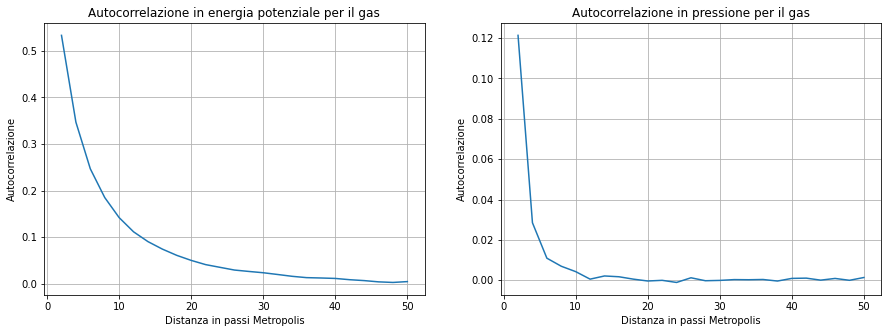

In [144]:
# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Grafico per l'energia potenziale
ax1.plot(tempi, Ac_energia)
ax1.set_xlabel('Distanza in passi Metropolis')
ax1.set_ylabel('Autocorrelazione')
ax1.set_title("Autocorrelazione in energia potenziale per il gas")
ax1.grid(True)

# Grafico per la pressione
ax2.plot(tempi, Ac_pressione)
ax2.set_xlabel('Distanza in passi Metropolis')
ax2.set_ylabel('Autocorrelazione')
ax2.set_title("Autocorrelazione in pressione per il gas")
ax2.grid(True)

L'autocorrelazione va molto velocemente a zero, cosa che mi potevo aspettare guardando come oscillano i valori istantanei. Inoltre si vede che l'autocorrelazione sulla pressione si annulla prima rispetto a quella sull'energia potenziale. Poichè l'autocorrelazione decade molto velocemente, mi aspetto di trovare il giusto valore dell'incertezza anche per blocchi di dimensione inferiore rispetto ai due casi precedenti.

In [145]:
# Calcola l'incertezza ottenuta dividendo in blocchi di lunghezza diversa
blocchi_ene = np.array([mediablocchi(energia_insta, nblocchi) for nblocchi in N])
blocchi_pres = np.array([mediablocchi(pressione_insta, nblocchi) for nblocchi in N])

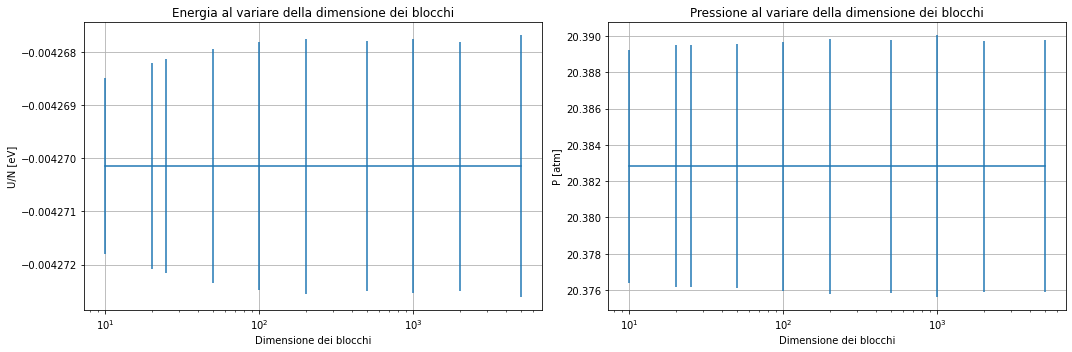

In [146]:
# Prepara due immagini
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), tight_layout = True)

# Grafico per l'energia potenziale
ax1.errorbar(L, blocchi_ene[:,0] * unitàE, yerr = blocchi_ene[:,1] * unitàE)
ax1.set_xlabel('Dimensione dei blocchi')
ax1.set_ylabel('U/N [eV]')
ax1.set_title("Energia al variare della dimensione dei blocchi")
ax1.set_xscale("log")
ax1.grid(True)

# Grafico per la pressione
ax2.errorbar(L, blocchi_pres[:,0] * unitàP, yerr = blocchi_pres[:,1] * unitàP)
ax2.set_xlabel('Dimensione dei blocchi')
ax2.set_ylabel('P [atm]')
ax2.set_title("Pressione al variare della dimensione dei blocchi")
ax2.set_xscale("log")
ax2.grid(True)

Dal grafico con l'energia potenziale si deduce che i blocchi devono contenere almeno $100$ step Metropolis. Il grafico sulla pressione raggiunge quasi da subito il valore corretto dell'incertezza.

## Calcolo della distribuzione radiale

Per il calcolo della distribuzione radiale devo misurare la distanza fra tutte le coppie di particelle ogni passo Metropolis. Nel programma questa parte è già compresa perchè è necessaria per il calcolo dell'energia potenziale e della pressione. Se trovo due particelle che si trovano a una distanza minore di $L/2$, dove $L$ è la lunghezza della mia cella, allora incremento il contatore del bin corrispondente di $2$. L'incremento non è unitario perchè nel codice considero ogni coppia solo una volta, ovvero considero soltanto la coppia $(i, j)$ dimenticandomi della $(j, i)$ che viene recuperata aggiungendo $2$ al posto di $1$. Fatto questo si procede con la solita media a blocchi. Quando devo aggiungere il valore del blocco alla somma e alla somma quadratica devo normalizzare correttamente i valori dei bin. Ogni bin deve essere normalizzato con $N \rho \Delta V$, dove $N$ è il numero di particelle, $\rho$ è la densità e $\Delta V$ è dato da

$$ \Delta V = \frac{4 \pi}{3} \bigg[\big(r + dr\big)^3 - r^3\bigg]$$

ma $r$ sono le posizioni dei miei bin, da cui segue $r_i = \frac{L}{2 \cdot nBins} (i - \frac{1}{2})$, dove come posizione del bin ho usato il punto medio del suo intervallo. La posizione $r + dr$ è soltanto il bin successivo, da cui segue 

$$ \Delta V_i = \frac{\pi L^3}{24 Bins^3} \bigg[1 + 12 i^2\bigg]$$

## Simulazioni energia, pressione e distribuzione radiale

Faccio una simulazione per ogni stato dell'argon in modo da avere dei valori progressivi di energia potenziale, pressione e distribuzione radiale. La distribuzione radiale la devo confrontare con quella ottenuta con la Dinamica Molecore. Per fare questo ho aggiunto al codice della lezione 4 lo stesso codice che ho utilizzato in questa esercitazione per il calcolo della distribuzione radiale.

### Solido

Ovviamente prima di fare una simulazione raggiungo l'equilibrazione. La seguente simulazione è stata fatta utilizzando $20$ blocchi, ognuno con $1000$ step Metropolis. La simulazione della distribuzione radiale ottenuta con la Dinamica Molecolare è stato ottenuta utilizzando $20$ blocchi da $1000$ passi Verlet.

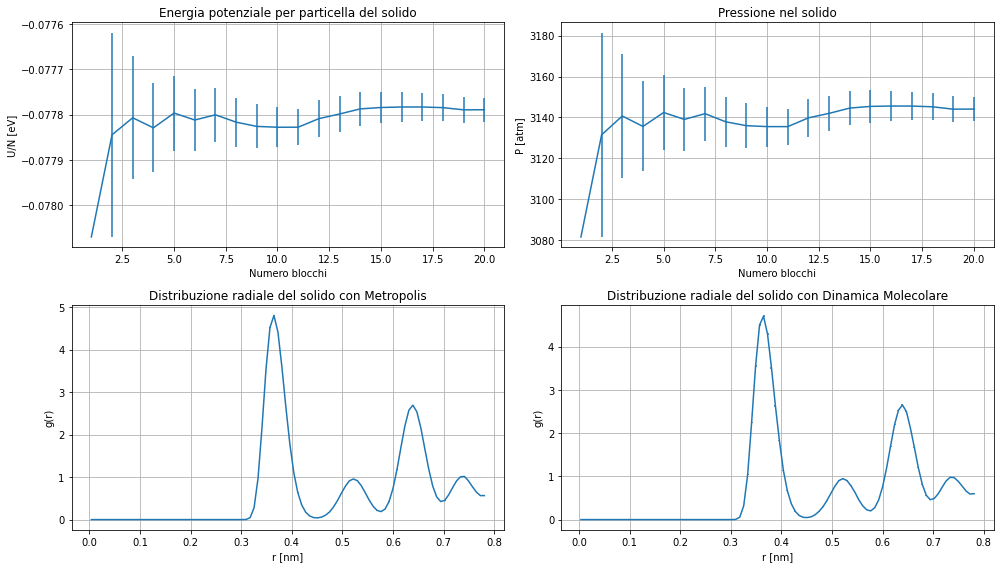

In [12]:
# Carica i dati
epot, epot_err = np.loadtxt("../Esercizio7/output.epot.0", usecols=(2,3), unpack='true') * unitàE
pres, pres_err = np.loadtxt("../Esercizio7/output.pres.0", usecols=(2,3), unpack='true') * unitàP
gMet, gMet_err = np.loadtxt("../Esercizio7/output.gave.0", usecols=(0,1), unpack='true')
gMol, gMol_err = np.loadtxt("../Esercizio4/ave.gofr.dat", usecols=(0,1), unpack='true')

# Vettori
x_ep = np.arange(20) + 1
x_g = (np.arange(100) + 0.5) * (108 / 1.1)**(1 / 3) / (2 * 100) * unitàL
assex = [x_ep, x_ep, x_g, x_g]
valori = [epot, pres, gMet, gMol]
errori = [epot_err, pres_err, gMet_err, gMol_err]
simboli = ["U/N [eV]", "P [atm]", "g(r)", "g(r)"]
label = ["Numero blocchi", "Numero blocchi", "r [nm]", "r [nm]"]

# Prepara quattro immagini
fig, ax = plt.subplots(2, 2, figsize = (14, 8), tight_layout = True)
ax = ax.reshape(-1)

# Plotta energia e pressione
for i in range(4):
    ax[i].errorbar(assex[i], valori[i], errori[i])
    ax[i].set_xlabel(label[i])
    ax[i].set_ylabel(simboli[i])
    ax[i].grid(True)
    
ax[0].set_title("Energia potenziale per particella del solido")
ax[1].set_title("Pressione nel solido")
ax[2].set_title("Distribuzione radiale del solido con Metropolis")
ax[3].set_title("Distribuzione radiale del solido con Dinamica Molecolare")
plt.show()

Dai grafici dell'andamento dell'energia potenziale e della pressione vediamo che questi tendono a convergere a un dato valore. I grafici delle due distribuzioni sono molto simili, ma le incertezze sono troppo piccole per riuscire a vederle. Facendo la differenza tra i due grafici si nota che le due distribuzioni non sono molto compatibili, infatti spesso distano qualche deviazione standard una dall'altra. Questo è probabilmente dovuto al fatto che la simulazione con la Dinamica Molecolare non riesce perfettamente a mantenere fissata la tempereratura e quindi genera una distribuzione leggermente differente.

### Liquido

Per la simulazione del liquido raggiungo l'equilibrazione e poi per la simulazione utilizzo gli stessi parametri usati per il solido.

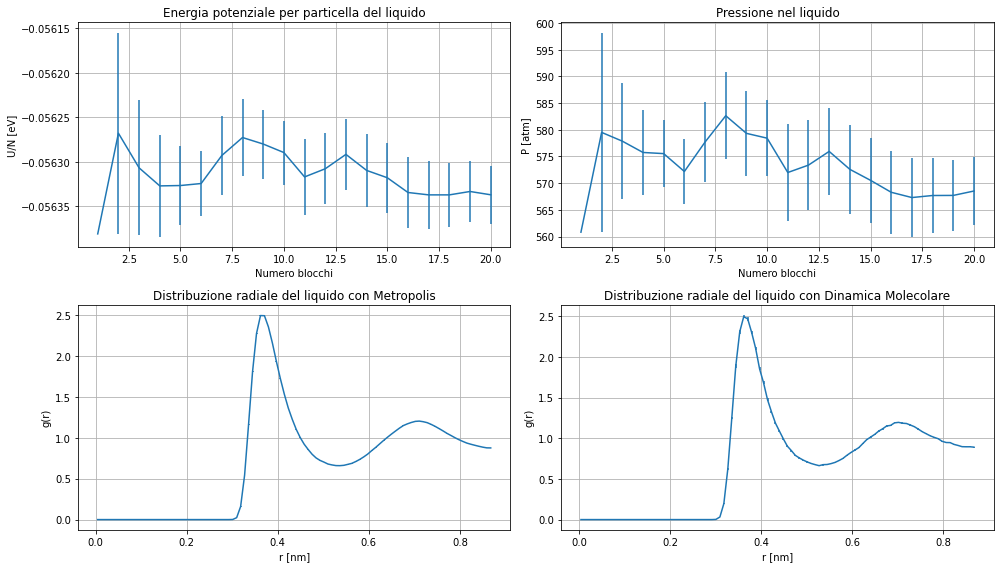

In [13]:
# Carica i dati
epot, epot_err = np.loadtxt("../Esercizio7/output.epot.0", usecols=(2,3), unpack='true') * unitàE
pres, pres_err = np.loadtxt("../Esercizio7/output.pres.0", usecols=(2,3), unpack='true') * unitàP
gMet, gMet_err = np.loadtxt("../Esercizio7/output.gave.0", usecols=(0,1), unpack='true')
gMol, gMol_err = np.loadtxt("../Esercizio4/ave.gofr.dat", usecols=(0,1), unpack='true')

# Vettori
x_ep = np.arange(20) + 1
x_g = (np.arange(100) + 0.5) * (108 / 0.8)**(1 / 3) / (2 * 100) * unitàL
assex = [x_ep, x_ep, x_g, x_g]
valori = [epot, pres, gMet, gMol]
errori = [epot_err, pres_err, gMet_err, gMol_err]
simboli = ["U/N [eV]", "P [atm]", "g(r)", "g(r)"]
label = ["Numero blocchi", "Numero blocchi", "r [nm]", "r [nm]"]

# Prepara quattro immagini
fig, ax = plt.subplots(2, 2, figsize = (14, 8), tight_layout = True)
ax = ax.reshape(-1)

# Plotta energia e pressione
for i in range(4):
    ax[i].errorbar(assex[i], valori[i], errori[i])
    ax[i].set_xlabel(label[i])
    ax[i].set_ylabel(simboli[i])
    ax[i].grid(True)
    
ax[0].set_title("Energia potenziale per particella del liquido")
ax[1].set_title("Pressione nel liquido")
ax[2].set_title("Distribuzione radiale del liquido con Metropolis")
ax[3].set_title("Distribuzione radiale del liquido con Dinamica Molecolare")
plt.show()

In questo caso i grafici dell'energia e della pressione oscillano maggiormente rispetto al caso precedente, infatti non si vede una chiara diminuzione dell'incertezza con l'aumentare del numero dei blocchi. Le distribuzioni radiali come nel caso precedente sembrano visivamente uguali ma guardando le incertezze non sono molto compatibili.

### Gas

Per la simulazione del gas raggiungo l'equilibrazione e poi per la simulazione utilizzo gli stessi parametri usati per il solido e per il liquido.

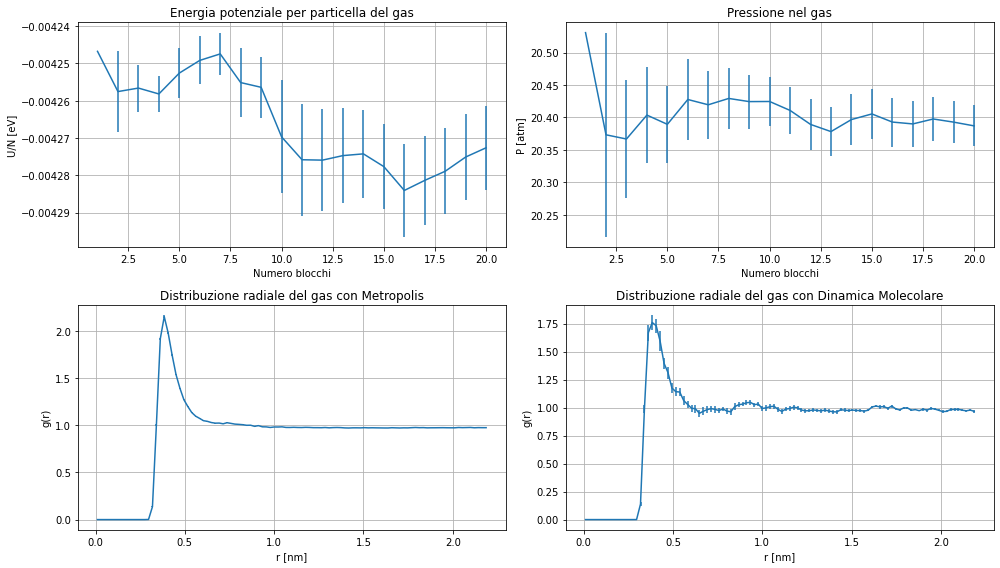

In [19]:
# Carica i dati
epot, epot_err = np.loadtxt("../Esercizio7/output.epot.0", usecols=(2,3), unpack='true') * unitàE
pres, pres_err = np.loadtxt("../Esercizio7/output.pres.0", usecols=(2,3), unpack='true') * unitàP
gMet, gMet_err = np.loadtxt("../Esercizio7/output.gave.0", usecols=(0,1), unpack='true')
gMol, gMol_err = np.loadtxt("../Esercizio4/ave.gofr.dat", usecols=(0,1), unpack='true')

# Vettori
x_ep = np.arange(20) + 1
x_g = (np.arange(100) + 0.5) * (108 / 0.05)**(1 / 3) / (2 * 100) * unitàL
assex = [x_ep, x_ep, x_g, x_g]
valori = [epot, pres, gMet, gMol]
errori = [epot_err, pres_err, gMet_err, gMol_err]
simboli = ["U/N [eV]", "P [atm]", "g(r)", "g(r)"]
label = ["Numero blocchi", "Numero blocchi", "r [nm]", "r [nm]"]

# Prepara quattro immagini
fig, ax = plt.subplots(2, 2, figsize = (14, 8), tight_layout = True)
ax = ax.reshape(-1)

# Plotta energia e pressione
for i in range(4):
    ax[i].errorbar(assex[i], valori[i], errori[i])
    ax[i].set_xlabel(label[i])
    ax[i].set_ylabel(simboli[i])
    ax[i].grid(True)
    
ax[0].set_title("Energia potenziale per particella del gas")
ax[1].set_title("Pressione nel gas")
ax[2].set_title("Distribuzione radiale del gas con Metropolis")
ax[3].set_title("Distribuzione radiale del gas con Dinamica Molecolare")
plt.show()

Il grafico della pressione tende a stabilizzarsi su un valore e si vede che la sua incertezza decresce con il numero dei blocchi. L'andamento dell'energia potenziale invece presenta una grossa oscillazione poco prima del decimo blocco. Questa molto probabilmente è dovuta a valori molto simili dei primi blocchi. I due grafici della distribuzione radiale sono simili, ma questa volta notiamo delle differenze. Nel risultato ottenuto con la Dinamica Molecolare questa volta si vedono le incertezze e inoltre il suo valore di picco è decisamente minore di quello ottenuto con Metropolis. Come nei casi precedenti nonostante la somiglianza delle due figure, queste non sono compatibili come si vede paragonando ad esempio i due valori al picco. In generale da queste simulazioni ho notato che la distribuzione ottenuta con Metropolis fornisce un grafico più preciso.